In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import os
from os.path import join as opj
%matplotlib inline

In [2]:
from mom6_design.postprocessing import plot_all, plot_cut, pad_ice_model, transpose_like_ref

In [3]:
path = '~/jjbuseck/model_setups/xanadu_mom6_20181101/OM4p125_IAF_csf_JRA55do1-3_r5_cycle4/archive'
refpath = opj(path,'restart_init_bgc_from_rest_1sec/ice_model.res.nc')
mergepath = opj(path,'restart_final_merged/ice_model.res.nc')

In [4]:
ds_merge = xr.open_mfdataset([mergepath])
# ds_merge

/discover/nobackup/jjbuseck/code/miniconda/envs/mom6_design/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/discover/nobackup/jjbuseck/code/miniconda/envs/mom6_design/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


In [5]:
ds_ref = xr.open_mfdataset([refpath])
# ds_ref

In [6]:
ds_diff = (ds_ref - ds_merge).squeeze().isel(zaxis_1=0, zaxis_2=0, aaxis_2=0).drop('H_to_kg_m2')

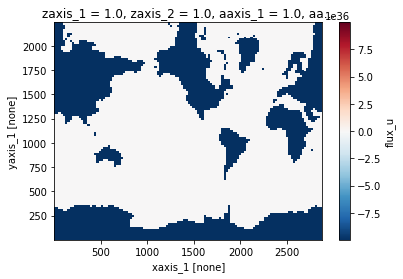

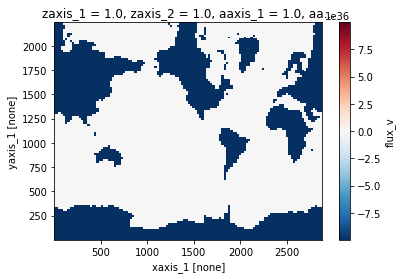

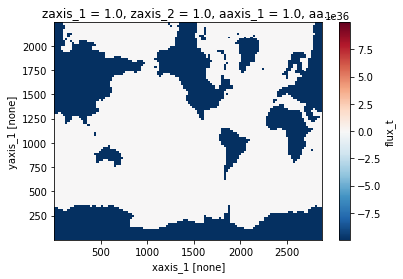

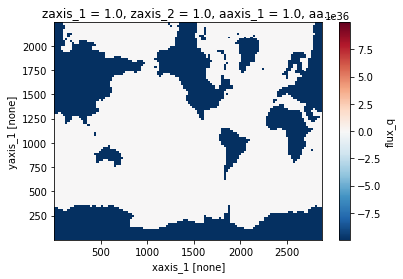

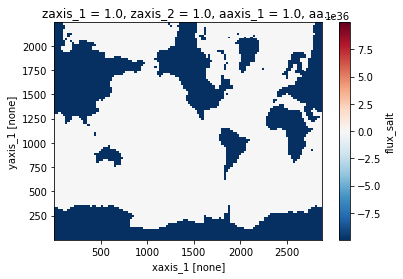

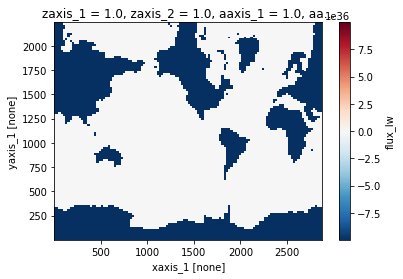

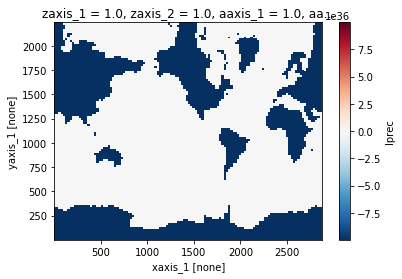

In [ ]:
plot_all(ds_diff, robust=True)

Ok lets padd everything with zeros and see how the differences looks

In [ ]:
ds_padded = transpose_like_ref(pad_ice_model(ds_merge), ds_ref)

The file is transposed in the exact way the reference file is, because it matters for MOM6 which dimension is on which axis

In [ ]:
plot_all(plot_cut(ds_padded), robust=True)

In [ ]:
ds_diff_padded = (ds_padded - ds_ref)

In [ ]:
plot_all(plot_cut(ds_diff_padded), robust=True)

Ok there are several candidates that might screw the ice up...lets look at part size first:

In [ ]:
ds_diff_padded.part_size.squeeze().plot(robust=True, col='zaxis_1')

In [ ]:
ds_padded.part_size.sum('zaxis_1').plot(robust=True)

In [ ]:
ds_padded.rough_moist.plot(col='zaxis_1', robust=True)

ds_ref.rough_moist.plot(col='zaxis_1', robust=True)

Ok so I fixed the part_size problem. It would not sum up to 1, as it should (I think)...that should raise an error though?
The remaining candidates are the sw/lw fluxes and the roughness...they are still different on the land...

In [ ]:
ds_padded

In [ ]:
ds_padded.to_netcdf('/gpfsm/dhome/jjbuseck/jjbuseck/model_setups/xanadu_mom6_20181101/OM4p125_IAF_csf_JRA55do1-3_r5_cycle4/archive/restart_combined_experimental/new/ice_model.res.nc.padded.fixed')

YIIIIIIIHHAAWWWWWWWW this worked! It was the `part_size` variable that was causing the issue!!!